# BERT Analysis

Approaching using BERT to analyze the overview column plan:
* Problem Understanding
  * Extract themes, genres, or patterns that correlate with popularity
  * BERT can reveal the underlying patterns by identifying contextual keywords and themes
* Using BERT for Key Information Extraction
  * BERT is a pre-trained model that reads text in both directions (both directions means that it reads starting from the left and the right side)
  * This is good for understanding word context better
  * Encoder vs. Decoder
    * Encoder: Extracts contextual information (good for classification, clustering)
      * Goal is to assign labels (genre, sentiment) based on the content OR Goal is to group similar texts together based on their meaning or themes
      * BERT understands word meanings more since it reads both left and right contexts
    * Decoder: Generates sequences (like summaries or paraphrasing)
  * Encoder would be best since we can classify the theme of the show as "romance," "heist," etc.
  * Decoder might be used if we need to summarize the overview or generate a more compact feature from it

# Feature Extractions via Embeddings
* Convert each overview into BERT embeddings, which is our vector representations
* Use a pre-trained BERT model form Hugging Face (bert-base-uncased) to generate enbeddings
  * BERT-base is the original configuration of the BERT model
  * Using uncased model since the capitalization does not impact the meaning
  * Will test the results of the BERT model on cleaned and uncleaned text data
    * Read that using over cleaned data into the BERT model can negatively affect its performance
  * Can use cosine similarity to show the similarity between overviews (clustering shows with similar themes)

In [1]:
import pandas as pd
import os
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

TMDB_filename = os.path.join(os.getcwd(), "TMDB_tv_dataset_v3.csv")
df = pd.read_csv(TMDB_filename)

/var/folders/m4/60ljkntj7gs489xq6yv_ghnm0000gn/T/ipykernel_18355/626329652.py:9: DtypeWarning: Columns (12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(TMDB_filename)


In [2]:
# import transformers library, which is a popular open-source library from HUgging Face
from transformers import BertTokenizer, BertModel
# import PyTorch to develop and train deep learning models
import torch
from tqdm import tqdm  # for progress bar

# loading the pre-trained BERT model and tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# tokenize and create tensor input
def get_embedding(text): 
  if pd.isnull(text):
    return torch.zeros(model.config.hidden_size).tolist()
  '''
  padding is set to true so that all input sequences have the same length
  truncation is set to true so that it truncates longer sequences that are longer
  than the models maximum input length so the text does not exceed the models capacity
  'return_tensor="pt"' means the output should be returned as a PyTorch tensor since the 
  model requires input in tensor format to perform computations
  '''
  tokens = tokenizer(text, padding=True, truncation=True, return_tensors="pt").to(device)
  '''
  torch.no_grad() disables gradient tracking to reduce memory consumption for computations that do not require gradients
  model(**tokens) passes the tokenized input to the pre-trained model (BERT)
  '''
  with torch.no_grad(): # generate embeddings 
    outputs = model(**tokens)
  '''
  outputs.last_hidden_state retrieves the hidden states from the last layer of the model for all tokens in the input sequence.
  Each token has an associated embedding vector.
  mean(dim=1) calculates the mean of the embeddings along the token dimension, which produces a single embedding vector for the entire input text, which
  can be used for various downstream tasks like classification, clustering, etc.
  '''
  return outputs.last_hidden_state.mean(dim=1).squeeze().tolist() # average pooling of embedings


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.0.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/safiaboutaleb/Developer/directv_tvrec/myenv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/safiaboutaleb/Developer/directv_tvrec/myenv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/safiaboutaleb/Developer/directv_tvrec/myenv/lib/python3.11/site-packages/ipyk

In [3]:
# function to process the DataFrame with progress tracking
def process_with_progress(series):
  embeddings = []
  for text in tqdm(series, desc="Processing Embeddings"):
    embeddings.append(get_embedding(text))
  return embeddings

In [4]:
filtered_df = df[(df['genres'].notna() & (df['genres'] != 'Unknown')) | (df['overview'].notna() & (df['overview'] != 'Unknown'))]

missing_both = df[(df['genres'].isna() | (df['genres'] == 'Unknown')) & (df['overview'].isna() | (df['overview'] == 'Unknown'))]

percentage_missing_both = (len(missing_both) / len(df)) * 100
print(f"Percentage of rows with both 'genres' and 'overview' missing: {percentage_missing_both:.2f}%")

Percentage of rows with both 'genres' and 'overview' missing: 0.91%


* Use the get_embedding function on the text data from the overview column

In [5]:
# process the overview column and assign embeddings to a new column
df['bert_cleaned_overview'] = process_with_progress(df['overview'])

print("Processing complete!")

Processing Embeddings: 100%|██████████| 168593/168593 [2:15:21<00:00, 20.76it/s]   


Processing complete!


In [6]:
# filter out rows where both 'genres' and 'overview' are either NaN or 'Unknown'
df_filtered = df[
  ~((df['genres'].isna() | (df['genres'] == 'Unknown')) & (df['overview'].isna() | (df['overview'] == 'Unknown')))
]
print(f"Filtered DataFrame shape: {df_filtered.shape}")

Filtered DataFrame shape: (167059, 120)


# Clustering/Classification
* After converting the overviews to embeddings:
  * Use clustering algorithms (K-Means) to find shows with similar themes
  * Classification model to predict genre based on overview content
  * If we noticed that certain clustered shows share a theme like "heist" we can make this a new feature in our dataset

In [7]:
# preprocess by ensuring the embeddings are in a suitable format (numpy array) and potentially normalize them
embeddings_array = np.vstack(df_filtered['bert_cleaned_overview'].to_numpy())

In [8]:
# use MiniBatchKMeans since it is a memory-efficient and faster version of KMeans that avoids some threading issues so we can do the clustering
from sklearn.cluster import MiniBatchKMeans

num_clusters = 5
kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=100)
df_filtered['cluster'] = kmeans.fit_predict(embeddings_array)

/Users/safiaboutaleb/Developer/directv_tvrec/myenv/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/var/folders/m4/60ljkntj7gs489xq6yv_ghnm0000gn/T/ipykernel_18355/76734131.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['cluster'] = kmeans.fit_predict(embeddings_array)


* Since we are using BERT-base embeddings, each embedding vector has 768 dimensions
* This means for every text in our dataset, there is a 768-dimensional vector

In [9]:
# inspect the shape to see the dimension of the data
print(f"Shape of embeddings array: {embeddings_array.shape}")

Shape of embeddings array: (167059, 768)


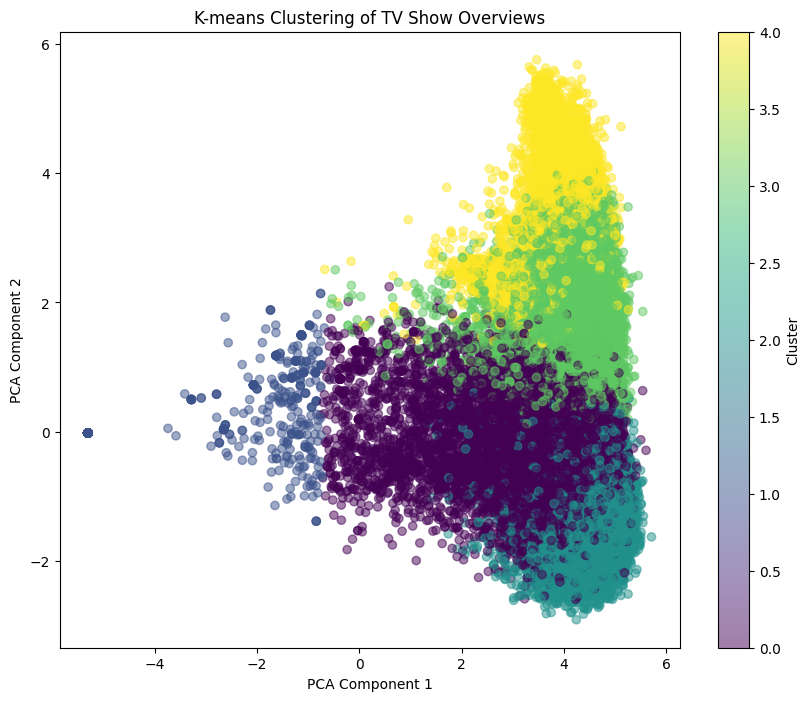

In [10]:
# using PCA to reduce dimensionality since the data is high-dimensional when visualizing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2) # reduce dimensions to 2 for visualization
reduced_embeddings = pca.fit_transform(embeddings_array)

plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=df_filtered['cluster'], cmap='viridis', alpha=0.5)
plt.title('K-means Clustering of TV Show Overviews')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

### K-means clustering results for TV show overviews reduced to two dimensions using PCA
* Axes (PCA Component 1 and 2)
  * The first two principle components resulting from PCA (PCA is used to reduce the dimensionality of the data)
  * Since the BERT embedings were high-dimensional, PCA was applied to project them in a 2D space
* Clusters
  * Each point represent a TV shows overview text that was converted into a BERT embedding
  * We specified 5 clusters, so the data points are grouped based on the similarity
  * The similarity between tv shows is based on the semantic meaning captured by the BERT embeddings
  * Shows that are closer have more similar content in their overviews, while shows in different clusters have distinct textual differences
  * The color bar on the right hand side indicates the cluster label assigned by the K-means algorithm
    * The numbers 0, 1, 2, 3, 4 correspond to different clusters
* Insights
  * The overlap in the clusters means that some TV shows share themes across multiple groups
  * The isolated blue cluster on the right could suggest a group of TV shows with overviews that are semantically distinct from other shows

### Next Steps
* Analyze the content of the clusters by looking at the shows in each group
* Experiment with more clusters

View Sample Data for Each Cluster

In [11]:
for cluster_id in range(num_clusters):
  print(f"\nCluster {cluster_id}:")
  display(df_filtered[df_filtered['cluster'] == cluster_id][['name', 'overview', 'genres']].head(10))


Cluster 0:


,name,overview,genres
5,Riverdale,"Set in the present, the series offers a bold, ...","['Crime', 'Drama', 'Mystery']"
6,Squid Game,Hundreds of cash-strapped players accept a str...,"['Action & Adventure', 'Mystery', 'Drama']"
13,Grey's Anatomy,Follows the personal and professional lives of...,['Drama']
30,Vikings,"The adventures of Ragnar Lothbrok, the greates...","['Action & Adventure', 'Drama', 'War & Politics']"
31,Dark,A missing child causes four families to help e...,"['Drama', 'Sci-Fi & Fantasy', 'Mystery']"
37,Chernobyl,The true story of one of the worst man-made ca...,['Drama']
38,American Horror Story,An anthology horror drama series centering on ...,"['Drama', 'Mystery', 'Sci-Fi & Fantasy']"
42,Westworld,A dark odyssey about the dawn of artificial co...,"['Sci-Fi & Fantasy', 'Western']"
47,Fear the Walking Dead,What did the world look like as it was transfo...,"['Action & Adventure', 'Drama']"
52,Black Mirror,"Over the last ten years, technology has transf...","['Sci-Fi & Fantasy', 'Drama', 'Mystery']"



Cluster 1:


,name,overview,genres
245,40 y 20,Unknown,['Comedy']
391,Ecomoda,Unknown,"['Comedy', 'Drama']"
441,Rosario Tijeras,Unknown,"['Action & Adventure', 'Crime', 'Drama']"
489,Rubi,Unknown,['Soap']
524,A Family of Ten,Unknown,['Comedy']
657,El Chapulín Colorado,Unknown,"['Comedy', 'Family', 'Crime', 'Sci-Fi & Fantas..."
719,María de Todos los Ángeles,Unknown,"['Drama', 'Comedy', 'Family']"
832,Amar a Muerte,Unknown,"['Drama', 'Soap']"
901,La Familia del Barrio,Unknown,['Comedy']
943,A Terra Prometida,Unknown,['Soap']



Cluster 2:


,name,overview,genres
0,Game of Thrones,Seven noble families fight for control of the ...,"['Sci-Fi & Fantasy', 'Drama', 'Action & Advent..."
1,Money Heist,"To carry out the biggest heist in history, a m...","['Crime', 'Drama']"
2,Stranger Things,"When a young boy vanishes, a small town uncove...","['Drama', 'Sci-Fi & Fantasy', 'Mystery']"
3,The Walking Dead,Sheriff's deputy Rick Grimes awakens from a co...,"['Action & Adventure', 'Drama', 'Sci-Fi & Fant..."
4,Lucifer,"Bored and unhappy as the Lord of Hell, Lucifer...","['Crime', 'Sci-Fi & Fantasy']"
7,Breaking Bad,"When Walter White, a New Mexico chemistry teac...","['Drama', 'Crime']"
8,The Good Doctor,"Shaun Murphy, a young surgeon with autism and ...",['Drama']
9,WandaVision,Wanda Maximoff and Vision—two super-powered be...,"['Sci-Fi & Fantasy', 'Mystery', 'Drama']"
10,The Flash,After a particle accelerator causes a freak st...,"['Drama', 'Sci-Fi & Fantasy']"
11,The Big Bang Theory,Physicists Leonard and Sheldon find their nerd...,['Comedy']



Cluster 3:


,name,overview,genres
15,The Simpsons,"Set in Springfield, the average American town,...","['Family', 'Animation', 'Comedy']"
93,"Yo soy Betty, la fea","Yo soy Betty, la fea is a telenovela filmed in...","['Soap', 'Comedy', 'Drama']"
321,What Life Took From Me,"""What Life Took From Me"" is a Mexican telenove...",['Drama']
368,Without Breasts There Is No Paradise,Sin Senos no hay Paraíso is a RTI Colombia–Tel...,"['Action & Adventure', 'Drama']"
407,Zoey 101,Zoey 101 is an American television series whic...,"['Drama', 'Comedy']"
473,Atrévete a soñar,"Danna Paola stars as Patito, Eleazar Gómez as ...",['Drama']
591,Justice League Unlimited,Justice League Unlimited is an American animat...,"['Animation', 'Action & Adventure']"
630,The Little Mermaid,Disney's The Little Mermaid is an American ani...,"['Family', 'Animation', 'Kids']"
643,PAW Patrol,PAW Patrol is a CG action-adventure for old ch...,"['Animation', 'Kids']"
650,The Killing,The Killing is an American crime drama televis...,"['Drama', 'Crime', 'Mystery']"



Cluster 4:


,name,overview,genres
388,The Tom and Jerry Show,The New Tom & Jerry Show is an animated televi...,"['Animation', 'Comedy', 'Kids', 'Family']"
500,Little House on the Prairie,Little House on the Prairie is an American Wes...,"['Western', 'Drama', 'Family']"
637,True Love,Amores verdaderos is a 2012 Mexican telenovela...,['Unknown']
649,Doña Bárbara,Doña Bárbara is a Spanish-language telenovela ...,"['Drama', 'Comedy', 'Soap']"
758,Doraemon,Doraemon is an anime TV series created by Fuji...,"['Action & Adventure', 'Animation', 'Comedy', ..."
816,Soy tu dueña,Soy Tu Dueña is a Mexican telenovela produced ...,['Drama']
1066,Café con Aroma de Mujer,Café con aroma de mujer is a 1994 Colombian te...,['Drama']
1133,The Cosby Show,The Cosby Show is an American television situa...,"['Comedy', 'Family']"
1279,Top Cat,Top Cat is a Hanna-Barbera prime time animated...,"['Animation', 'Comedy', 'Kids']"
1337,According to Jim,According to Jim is an American sitcom televis...,['Comedy']


Get Genre Distributions per Cluster

In [12]:
'''
# create a breakdown of genres in each cluster
for cluster_id in range(num_clusters):
    print(f"\nCluster {cluster_id} Genre Distribution:")
    genre_counts = df[df['cluster'] == cluster_id]['genres'].value_counts()
    print(genre_counts.head(10))  # show top 10 most common genres
'''

# iterate over each cluster to display the top 10 genres for each cluster
for cluster_id in range(num_clusters):
	print(f"\nCluster {cluster_id} Genre Distribution:")
	cluster_df = df_filtered[df_filtered['cluster'] == cluster_id]
	genre_sums = cluster_df.loc[:, 'Action & Adventure':'Western'].sum()
	sorted_genres = genre_sums.sort_values(ascending=False)
	print(sorted_genres.head(10))


Cluster 0 Genre Distribution:
Documentary           10547.0
Reality                4833.0
Drama                  4256.0
Comedy                 3887.0
Unknown                3004.0
Action & Adventure     2725.0
Family                 1753.0
Crime                  1644.0
Animation              1466.0
Talk                   1272.0
dtype: float64

Cluster 1 Genre Distribution:
Unknown        39568.0
Drama           9898.0
Documentary     9364.0
Comedy          6605.0
Reality         4436.0
Animation       2729.0
Family          2679.0
Crime           2035.0
Talk            1761.0
Kids            1757.0
dtype: float64

Cluster 2 Genre Distribution:
Drama                 16491.0
Comedy                 8539.0
Animation              6066.0
Action & Adventure     5138.0
Sci-Fi & Fantasy       4045.0
Crime                  3350.0
Mystery                2818.0
Family                 2749.0
Kids                   1149.0
Unknown                1004.0
dtype: float64

Cluster 3 Genre Distribution:
C

Plot Genre Distribution Per Cluster For Visual Comparison

In [13]:
'''
# flatten genres into individual entries
df_exploded = df.explode('genres')  # if 'genres' is a list

plt.figure(figsize=(15, 5))
sns.countplot(data=df_exploded, x='genres', hue='cluster')
plt.xticks(rotation=90)
plt.title("Genre Distribution by Cluster")
plt.show()
'''

'\n# flatten genres into individual entries\ndf_exploded = df.explode(\'genres\')  # if \'genres\' is a list\n\nplt.figure(figsize=(15, 5))\nsns.countplot(data=df_exploded, x=\'genres\', hue=\'cluster\')\nplt.xticks(rotation=90)\nplt.title("Genre Distribution by Cluster")\nplt.show()\n'

Identify Themes or Topics in Overviews

In [14]:
import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords

# get the list of stop words
stop_words = set(stopwords.words('english'))

In [15]:
from collections import Counter
import re

# function to get the top words from overviews in a given cluster
def get_top_words(cluster_id, num_words=20):
  overviews = df_filtered[df_filtered['cluster'] == cluster_id]['overview'].fillna('')
  
  # combine all overviews into a single string, and split into words
  all_words = ' '.join(overviews).lower()
  
  # remove punctuation and split into words
  all_words = re.findall(r'\b\w+\b', all_words)
  
  # filter out stop words
  filtered_words = [word for word in all_words if word not in stop_words]
  
  # count word frequencies
  word_counts = Counter(filtered_words)
  
  return word_counts.most_common(num_words)

# print the top words for each cluster
for cluster_id in range(num_clusters):
  print(f"\nTop words in Cluster {cluster_id}:")
  print(get_top_words(cluster_id))


Top words in Cluster 0:
[('series', 7771), ('world', 5548), ('life', 4019), ('new', 3800), ('show', 3790), ('one', 3400), ('people', 2824), ('story', 2514), ('stories', 2468), ('history', 2440), ('lives', 2127), ('documentary', 2074), ('time', 1958), ('family', 1888), ('first', 1855), ('two', 1824), ('behind', 1620), ('part', 1614), ('love', 1597), ('around', 1584)]

Top words in Cluster 1:
[('unknown', 74407), ('show', 52), ('miniseries', 50), ('series', 30), ('tv', 28), ('drama', 20), ('variety', 19), ('overview', 15), ('details', 15), ('german', 14), ('italian', 11), ('edit', 11), ('available', 10), ('translation', 10), ('french', 8), ('documentary', 8), ('commented', 7), ('reality', 7), ('thai', 6), ('comedy', 5)]

Top words in Cluster 2:
[('life', 8005), ('love', 6868), ('one', 6586), ('family', 6176), ('two', 4819), ('story', 4803), ('young', 4777), ('school', 4552), ('new', 4434), ('world', 4371), ('man', 3855), ('time', 3722), ('years', 3678), ('girl', 3506), ('day', 3408), ('

Creating a Word Cloud for Each Cluster

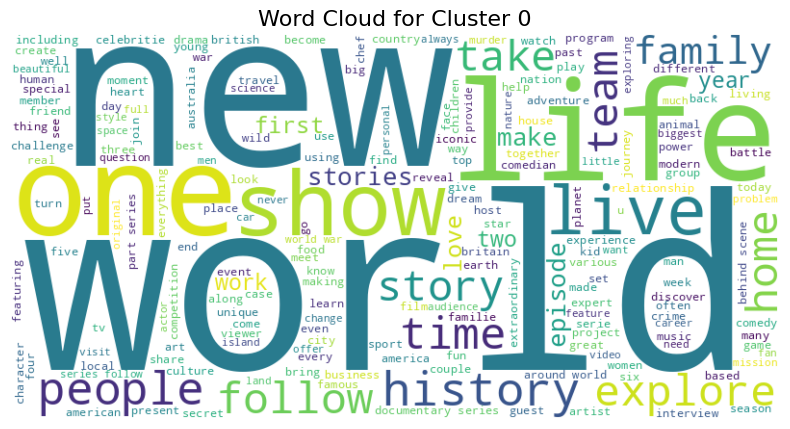

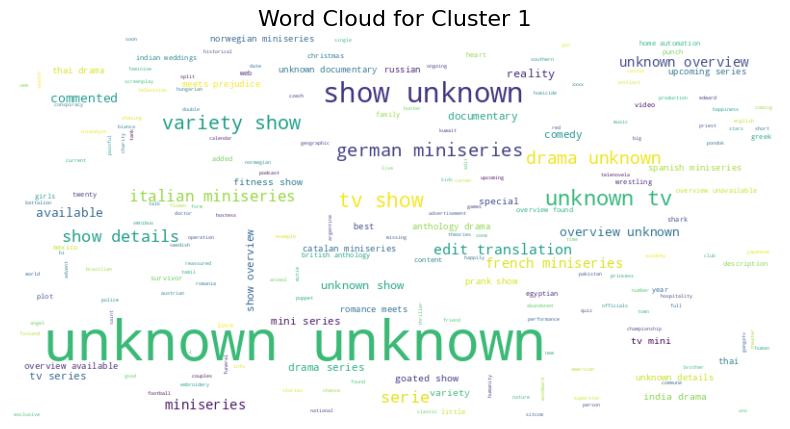

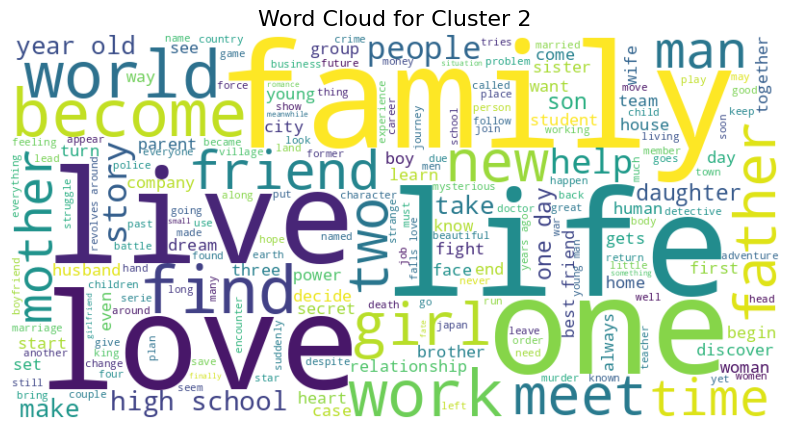

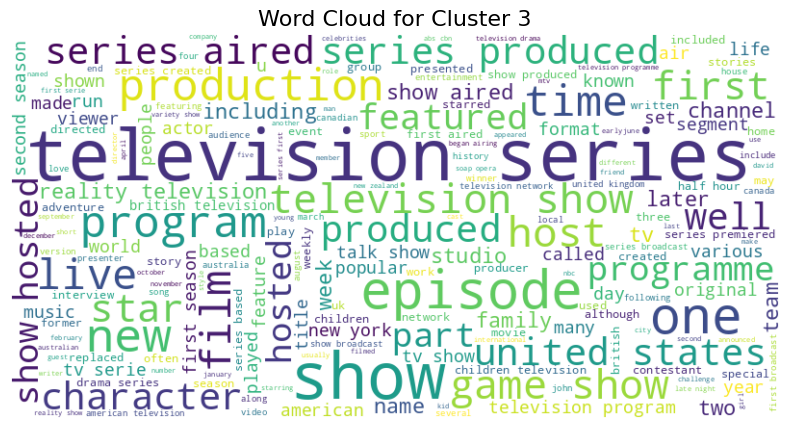

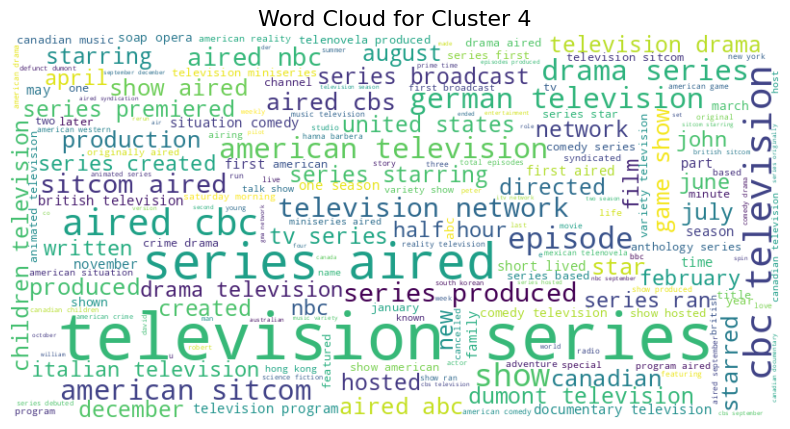

In [16]:
from wordcloud import WordCloud

def generate_word_cloud(cluster_id):
  overviews = df_filtered[df_filtered['cluster'] == cluster_id]['overview'].fillna('')
  all_words = ' '.join(overviews).lower()
  words = re.findall(r'\b\w+\b', all_words)
  filtered_words = [word for word in words if word not in stop_words]
  text = ' '.join(filtered_words)

  # create the word cloud object
  wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
  
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Cluster {cluster_id}', fontsize=16)
  plt.show()

# generate word clouds for all clusters
for cluster_id in range(num_clusters):
  generate_word_cloud(cluster_id)


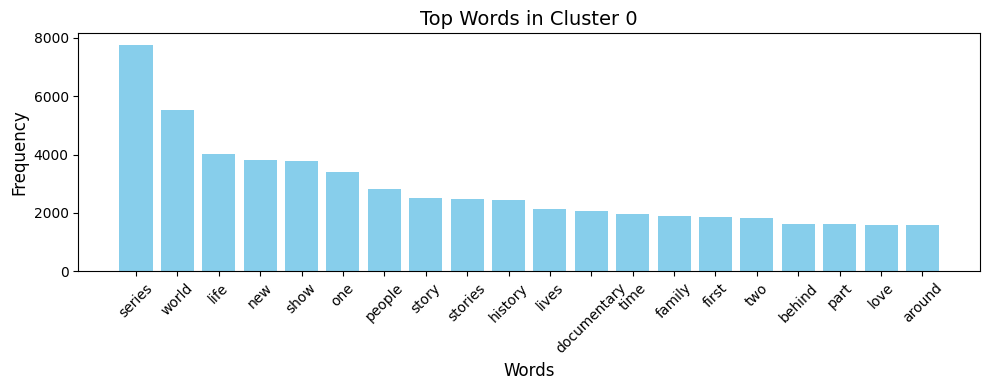

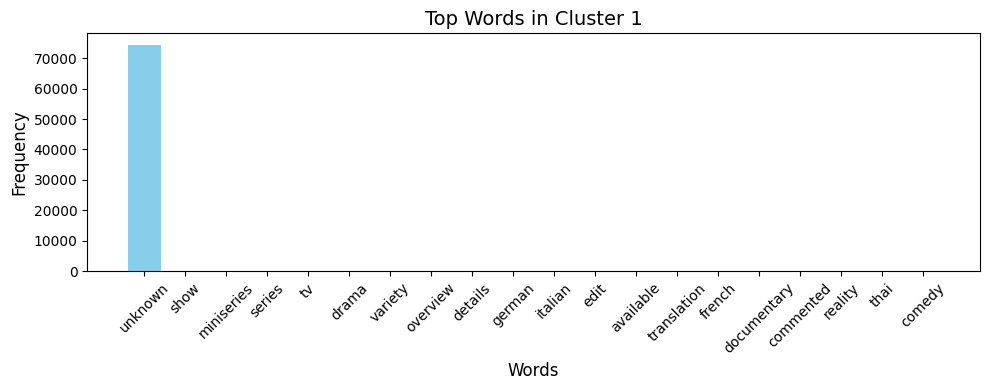

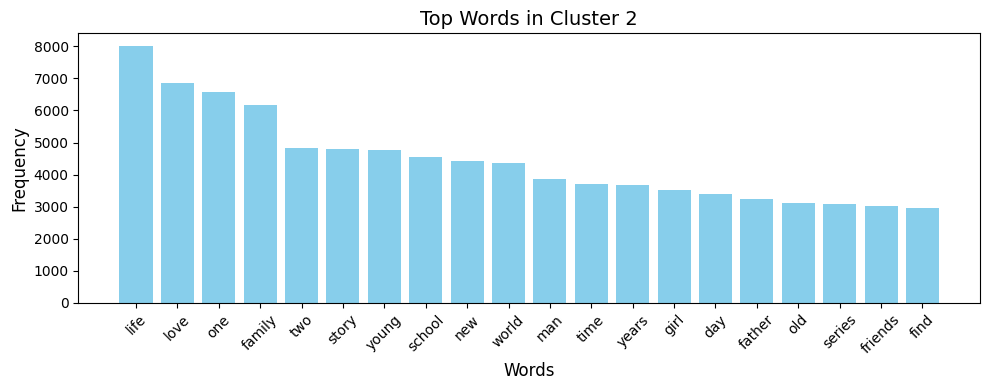

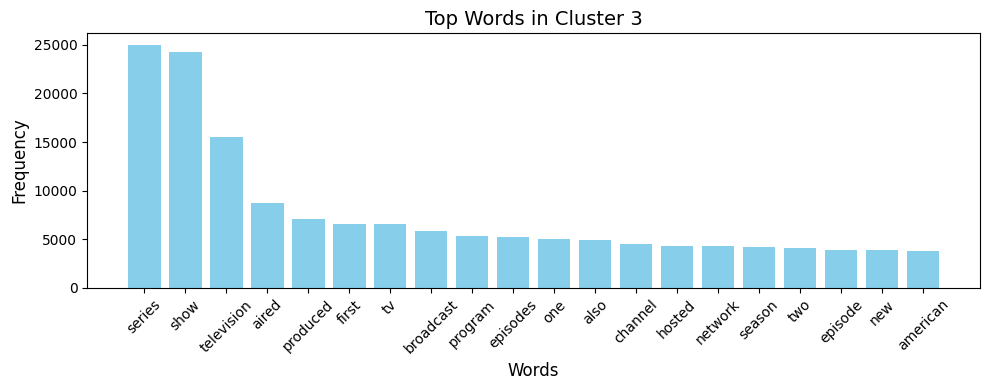

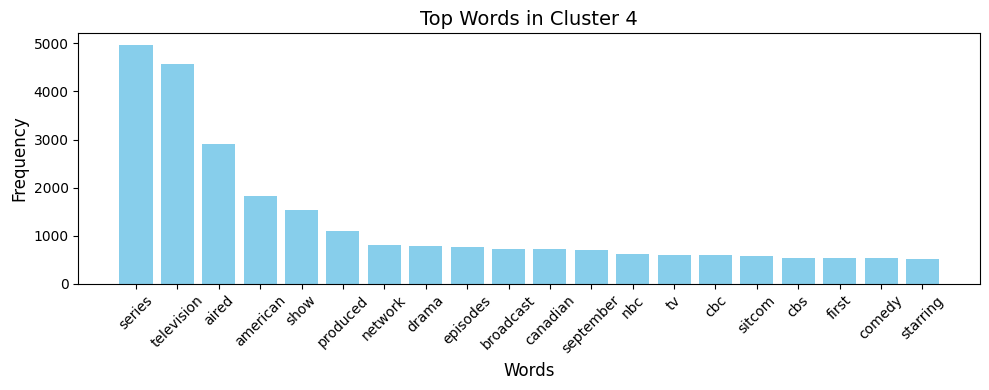

In [20]:
cluster_top_words = {}
for cluster_id in range(num_clusters):
  cluster_top_words[cluster_id] = get_top_words(cluster_id)

# plot the top words of each cluster
for cluster_id in range(num_clusters):
	# get top words and their counts for the current cluster
	words, counts = zip(*get_top_words(cluster_id))
	
	plt.figure(figsize=(10, 4))
	plt.bar(words, counts, color='skyblue')
	plt.title(f"Top Words in Cluster {cluster_id}", fontsize=14)
	plt.xlabel("Words", fontsize=12)
	plt.ylabel("Frequency", fontsize=12)
	plt.xticks(rotation=45, fontsize=10)
	plt.tight_layout() 
	plt.show()

In [23]:
from IPython.display import display, HTML

# filter rows where the word "family" appears in the 'overview' column
family_shows = df_filtered[df_filtered['cleaned_overview'].str.contains(r'\bfamily\b', case=False, na=False)]

html_output = family_shows[['name', 'popularity']].to_html()
display(HTML(f'<div style="max-height: 300px; overflow-y: scroll;">{html_output}</div>'))

,name,popularity
0,Game of Thrones,0.292397
3,The Walking Dead,0.132114
7,Breaking Bad,0.066801
15,The Simpsons,0.118556
17,The Umbrella Academy,0.013989
18,Peaky Blinders,0.092926
21,Rick and Morty,0.115739
26,Wednesday,0.044315
30,Vikings,0.079362
31,Dark,0.023432


In [25]:
# create a new feature 'has_family' that is 1 if 'family' is in the overview, else 0
df['has_family'] = df['cleaned_overview'].fillna('').str.contains(r'\bfamily\b', case=False, na=False).astype(int)

print(df[['cleaned_overview', 'has_family']].head())

                                    cleaned_overview  has_family
0  seven noble family fight control mythical land...           1
1  carry biggest heist history mysterious man cal...           0
2  young boy vanishes small town uncovers mystery...           0
3  sheriff deputy rick grime awakens coma find po...           1
4  bored unhappy lord hell lucifer morningstar ab...           0


In [26]:
print(df['has_family'].value_counts())

has_family
0    160274
1      8319
Name: count, dtype: int64


In [27]:
# Good seperation of clusters
# Popularities for each cluster
# Getting a tag (boolean fld ex: including the word 'world')
# If a word is very popular, or two words are corelated ot eachother, find relations between words
# create a feature based on the word (can be multiple words)
# family an dlove can be a feature
# because we are missing 44% of the data, we should combine the overview column with another feature
# if we are able to get a genre for that, we can consider the other 44 percent, so we can populate the missing genre
# Witht he overview column, we can consider how the model performs with the overview column and without it
# If it is not making much of a difference, we can exclude it
# Simple model to predict the existing popularity

# llamma model 

In [28]:
average_popularity_per_cluster = df_filtered.groupby('cluster')['popularity'].mean()

print("Average Popularity per Cluster:")
print(average_popularity_per_cluster)

Average Popularity per Cluster:
cluster
0    0.001786
1    0.000667
2    0.003076
3    0.002133
4    0.002336
Name: popularity, dtype: float64


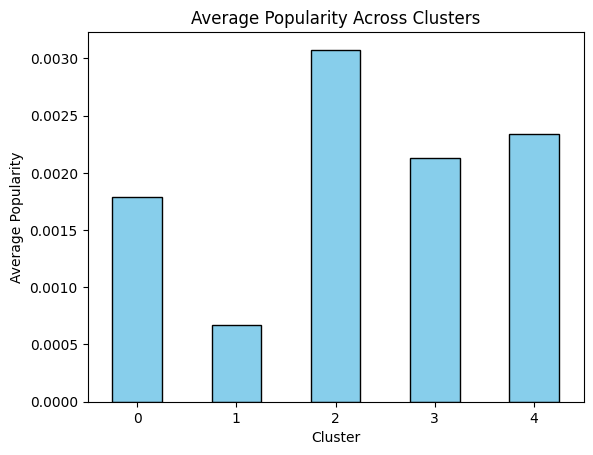

In [29]:
# Bar plot to visualize average popularity for each cluster
average_popularity_per_cluster.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Cluster')
plt.ylabel('Average Popularity')
plt.title('Average Popularity Across Clusters')
plt.xticks(rotation=0)
plt.show()

# do some log transformation
# check how many rows have a missing overview but has a genre and vice versa
# If both are missing we can ignore for now and see how the BERT model performs

In [30]:
correlation = df_filtered['popularity'].corr(df_filtered['cluster'])
print(f"Correlation between Popularity and Clusters: {correlation}")

Correlation between Popularity and Clusters: 0.03920952014741139


In [31]:
# missing or 'Unknown' overview but a valid genre
missing_or_unknown_overview_with_genre = df[
  (df['overview'].isna() | (df['overview'] == 'Unknown')) & 
  ~(df['genres'].isna() | (df['genres'] == 'Unknown'))
]
count_missing_or_unknown_overview_with_genre = missing_or_unknown_overview_with_genre.shape[0]

# missing or 'Unknown' genre but a valid overview
missing_or_unknown_genre_with_overview = df[
  (df['genres'].isna() | (df['genres'] == 'Unknown')) & 
  ~(df['overview'].isna() | (df['overview'] == 'Unknown'))
]
count_missing_or_unknown_genre_with_overview = missing_or_unknown_genre_with_overview.shape[0]

print(f"Number of rows with missing or 'Unknown' overview but a valid genre: {count_missing_or_unknown_overview_with_genre}")
print(f"Number of rows with missing or 'Unknown' genre but a valid overview: {count_missing_or_unknown_genre_with_overview}")


Number of rows with missing or 'Unknown' overview but a valid genre: 74405
Number of rows with missing or 'Unknown' genre but a valid overview: 0


In [32]:
# save the DataFrame to a CSV file without the BERT embeddings
column_to_exclude = 'bert_cleaned_overview'
df.drop(columns=[column_to_exclude]).to_csv("TMDB_tv_dataset_v3.csv", index=False)